# Bayesian Structural Time Series Analysis

This notebook shows how Bayesian structural time series (BSTS) analysis can be used to decompose and forecast time series for enterprise needs. For the sake of illustration, we focus on demand decomposition and forecasting use case.

This tutorial is structured as follows:
* We use a public dataset that contains about 2 months of electricity demand and temperature (which is a regressor in this case) values with hourly resolution.
* In the first part, we develop and fit an autoregressive model with trend and seasonality components using PyMC3. The implementation is based on this [example](https://docs.pymc.io/notebooks/GP-MaunaLoa.html).
* In the second part, we develop a more advanced model using Structural Time Series library from TensorFlow Probabilistic. The implementation is adoped from this [example](https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html).  
* In the third part, we do decomposition and forecasting for the same demand time series using Facebook's Prophet.

In [1]:
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import collections
import numpy as np
import pandas as pd

In [2]:
demand_dates = np.arange('2014-01-01', '2014-02-26', dtype='datetime64[h]')
demand_loc = mdates.WeekdayLocator(byweekday=mdates.WE)
demand_fmt = mdates.DateFormatter('%a %b %d')

data = pd.read_csv('../resources/small-datasets/electricity-demand-victoria.csv', comment='#', header=None).T
data = pd.concat([data, pd.DataFrame(demand_dates)], axis=1)
data.columns = ["demand", "temperature", "date"]

num_forecast_steps = 24 * 7 * 2 # two weeks
data_training = data[:-num_forecast_steps]
data_test = data[-num_forecast_steps:]

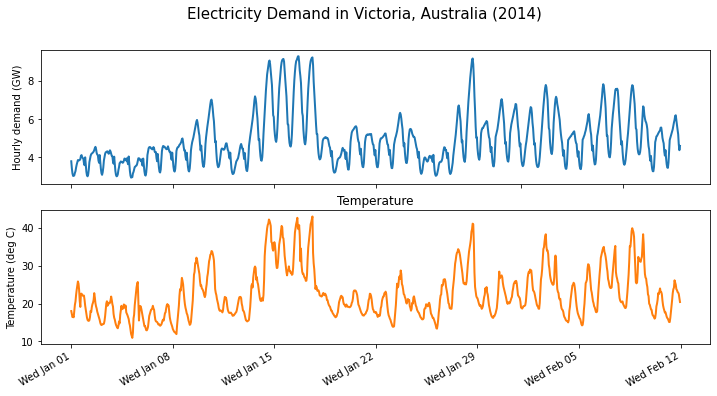

In [3]:
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(data_training.date,
        data_training.demand, lw=2, label="training data")
ax.set_ylabel("Hourly demand (GW)")

ax = fig.add_subplot(2, 1, 2)

ax.plot(data_training.date,
        data_training.temperature, lw=2, label="training data", c=c2)
ax.set_ylabel("Temperature (deg C)")
ax.set_title("Temperature")
ax.xaxis.set_major_locator(demand_loc)
ax.xaxis.set_major_formatter(demand_fmt)
fig.suptitle("Electricity Demand in Victoria, Australia (2014)", fontsize=15)
fig.autofmt_xdate()

# Plotting Functions

In [4]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

In [5]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_steps_forecast

  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
  ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
  """Plot the contributions of posterior components in a single figure."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(12, 2.5 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
  fig.autofmt_xdate()
  fig.tight_layout()
  return fig, axes_dict

# Part 1. Decomposition and Forecasting Using PyMC3

In [6]:
import pymc3 as pm
import arviz as az
print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


In [7]:
def dates_to_idx(timelist):
    reference_time = pd.to_datetime('2014-01-01')
    t = (timelist - reference_time) / pd.Timedelta(1, "D")
    return np.asarray(t)

t = dates_to_idx(data_training.date)[:,None]
y = data_training.demand.values
print(t.shape, y.shape)

first_y = 0
std_y = 1

(1008, 1) (1008,)


## Model Specification and Fitting

We use additive Gaussian processes model originally described in "Gaussian Processes for Machine Learning" book by C. Rasmussen and C. Williams, The MIT Press, 2006. 

Lengthscale priors:
* ℓ_pdecay: The periodic decay. The smaller this parameter is, the faster the periodicity goes away.
* ℓ_psmooth: The smoothness of the periodic component. It controls how “sinusoidal” the periodicity is.
* period: The period. We put a strong prior on a period of one day.
* ℓ_med: This is the lengthscale for the short to medium long variations.
* α: This is the shape parameter.
* ℓ_trend: The lengthscale of the long term trend.
* ℓ_noise: The lengthscale of the noise covariance.

Scale priors:
* η_per: Scale of the periodic or seasonal component.
* η_med: Scale of the short to medium term component.
* η_trend: Scale of the long term trend.
* σ: Scale of the white noise.
* η_noise: Scale of correlated, short term noise.

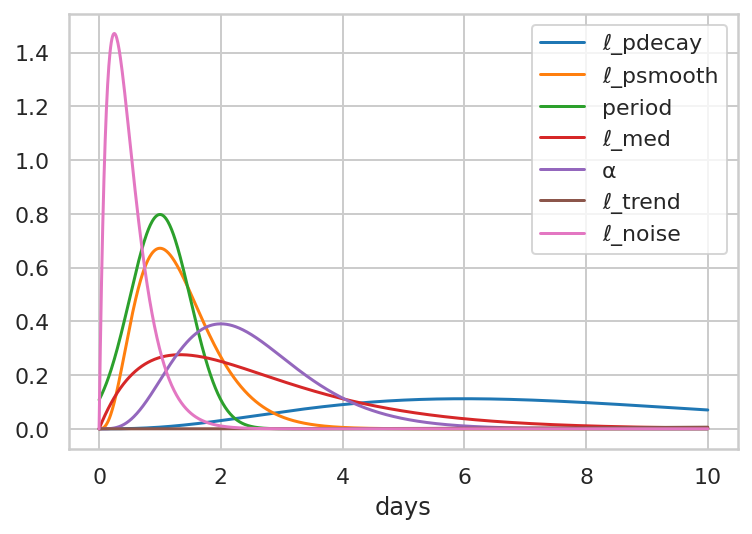

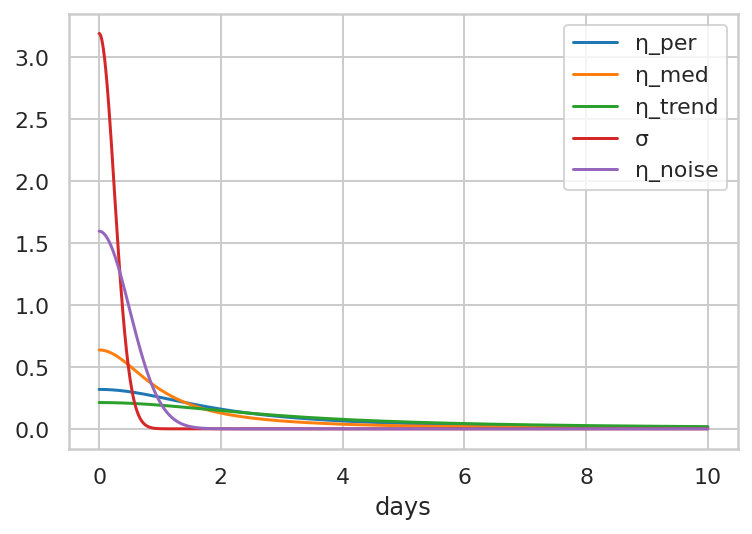

In [45]:
# plot the priors
x = np.linspace(0, 10, 1000)
priors = [
    ("ℓ_pdecay",  pm.Gamma.dist(alpha=4, beta=0.5)),
    ("ℓ_psmooth", pm.Gamma.dist(alpha=4,  beta=3)),
    ("period",    pm.Normal.dist(mu=1.0,  sigma=0.5)),
    ("ℓ_med",     pm.Gamma.dist(alpha=2,  beta=0.75)),
    ("α",         pm.Gamma.dist(alpha=5,  beta=2)),
    ("ℓ_trend",   pm.Gamma.dist(alpha=4,  beta=0.1)),
    ("ℓ_noise",   pm.Gamma.dist(alpha=2,  beta=4))]

for i, prior in enumerate(priors):
    plt.plot(x, np.exp(prior[1].logp(x).eval()), label=prior[0])
plt.legend(loc="upper right")
plt.xlabel("days")
plt.show();

x = np.linspace(0, 10, 1000)
priors = [
    ("η_per",   pm.HalfCauchy.dist(beta=2)),
    ("η_med",   pm.HalfCauchy.dist(beta=1.0)),
    ("η_trend", pm.HalfCauchy.dist(beta=3)), 
    ("σ",       pm.HalfNormal.dist(sigma=0.25)),
    ("η_noise", pm.HalfNormal.dist(sigma=0.5))]

for i, prior in enumerate(priors):
    plt.plot(x, np.exp(prior[1].logp(x).eval()), label=prior[0])
plt.legend(loc="upper right")
plt.xlabel("days")
plt.show();

In [ ]:
with pm.Model() as model:
    # daily periodic component x long term trend
    η_per = pm.HalfCauchy("η_per", beta=2, testval=1.0)
    ℓ_pdecay = pm.Gamma("ℓ_pdecay", alpha=4, beta=0.5)
    period  = pm.Normal("period", mu=1, sigma=0.5)
    ℓ_psmooth = pm.Gamma("ℓ_psmooth ", alpha=4, beta=3)
    cov_seasonal = η_per**2 * pm.gp.cov.Periodic(1, period, ℓ_psmooth) \
                            * pm.gp.cov.Matern52(1, ℓ_pdecay)
    gp_seasonal = pm.gp.Marginal(cov_func=cov_seasonal)

    # small/medium term irregularities
    η_med = pm.HalfCauchy("η_med", beta=0.5, testval=0.1)
    ℓ_med = pm.Gamma("ℓ_med", alpha=2, beta=0.75)
    α = pm.Gamma("α", alpha=5, beta=2)
    cov_medium = η_med**2 * pm.gp.cov.RatQuad(1, ℓ_med, α)
    gp_medium = pm.gp.Marginal(cov_func=cov_medium)

    # long term trend
    η_trend = pm.HalfCauchy("η_trend", beta=2, testval=2.0)
    ℓ_trend = pm.Gamma("ℓ_trend", alpha=4, beta=0.1)
    cov_trend = η_trend**2 * pm.gp.cov.ExpQuad(1, ℓ_trend)
    gp_trend = pm.gp.Marginal(cov_func=cov_trend)

    # noise model
    η_noise = pm.HalfNormal("η_noise", sigma=0.5, testval=0.05)
    ℓ_noise = pm.Gamma("ℓ_noise", alpha=2, beta=4)
    σ  = pm.HalfNormal("σ",  sigma=0.25, testval=0.05)
    cov_noise = η_noise**2 * pm.gp.cov.Matern32(1, ℓ_noise) +\
                pm.gp.cov.WhiteNoise(σ)

    # The Gaussian process is a sum of these three components
    gp = gp_seasonal + gp_medium + gp_trend

    # Since the normal noise model and the GP are conjugates, we use `Marginal` with the `.marginal_likelihood` method
    y_ = gp.marginal_likelihood("y", X=t, y=y, noise=cov_noise)

    # this line calls an optimizer to find the MAP
    mp = pm.find_MAP(include_transformed=True)

In [11]:
# fitted model parameters
sorted([name+":"+str(mp[name]) for name in mp.keys() if not name.endswith("_")])

['period:0.9999606532905599',
 'α:2.0605796376538676',
 'η_med:0.09978818283532753',
 'η_noise:1.0690093442843527',
 'η_per:0.4701524024353513',
 'η_trend:2.734860954631787',
 'σ:0.0002244648148150272',
 'ℓ_med:1.8929785666501273',
 'ℓ_noise:0.5253764826322195',
 'ℓ_pdecay:59.205992564164774',
 'ℓ_psmooth :0.18001341762095077',
 'ℓ_trend:43.70427979646954']

## Demand Series Decomposition

In [ ]:
# predict at a 1 hour granularity
dates = pd.date_range(start='2014-01-01', end="2014-02-12", freq="1H")[:-1]
tnew = dates_to_idx(dates)[:,None]

print("Predicting with gp ...")
mu, var = gp.predict(tnew, point=mp, diag=True)
mean_pred = mu*std_y + first_y
var_pred  = var*std_y**2

# make dataframe to store fit results
fit = pd.DataFrame({"t": tnew.flatten(),
                    "mu_total": mean_pred,
                    "sd_total": np.sqrt(var_pred)},
                   index=dates)

print("Predicting with gp_trend ...")
mu, var = gp_trend.predict(tnew, point=mp,
                           given={"gp": gp, "X": t, "y": y, "noise": cov_noise},
                           diag=True)
fit = fit.assign(mu_trend = mu*std_y + first_y,
                 sd_trend = np.sqrt(var*std_y**2))

print("Predicting with gp_medium ...")
mu, var = gp_medium.predict(tnew, point=mp,
                            given={"gp": gp, "X": t, "y": y, "noise": cov_noise},
                            diag=True)
fit = fit.assign(mu_medium = mu*std_y + first_y,
                 sd_medium = np.sqrt(var*std_y**2))

print("Predicting with gp_seasonal ...")
mu, var = gp_seasonal.predict(tnew, point=mp,
                              given={"gp": gp, "X": t, "y": y, "noise": cov_noise},
                              diag=True)
fit = fit.assign(mu_seasonal = mu*std_y + first_y,
                 sd_seasonal = np.sqrt(var*std_y**2))

print("Done")

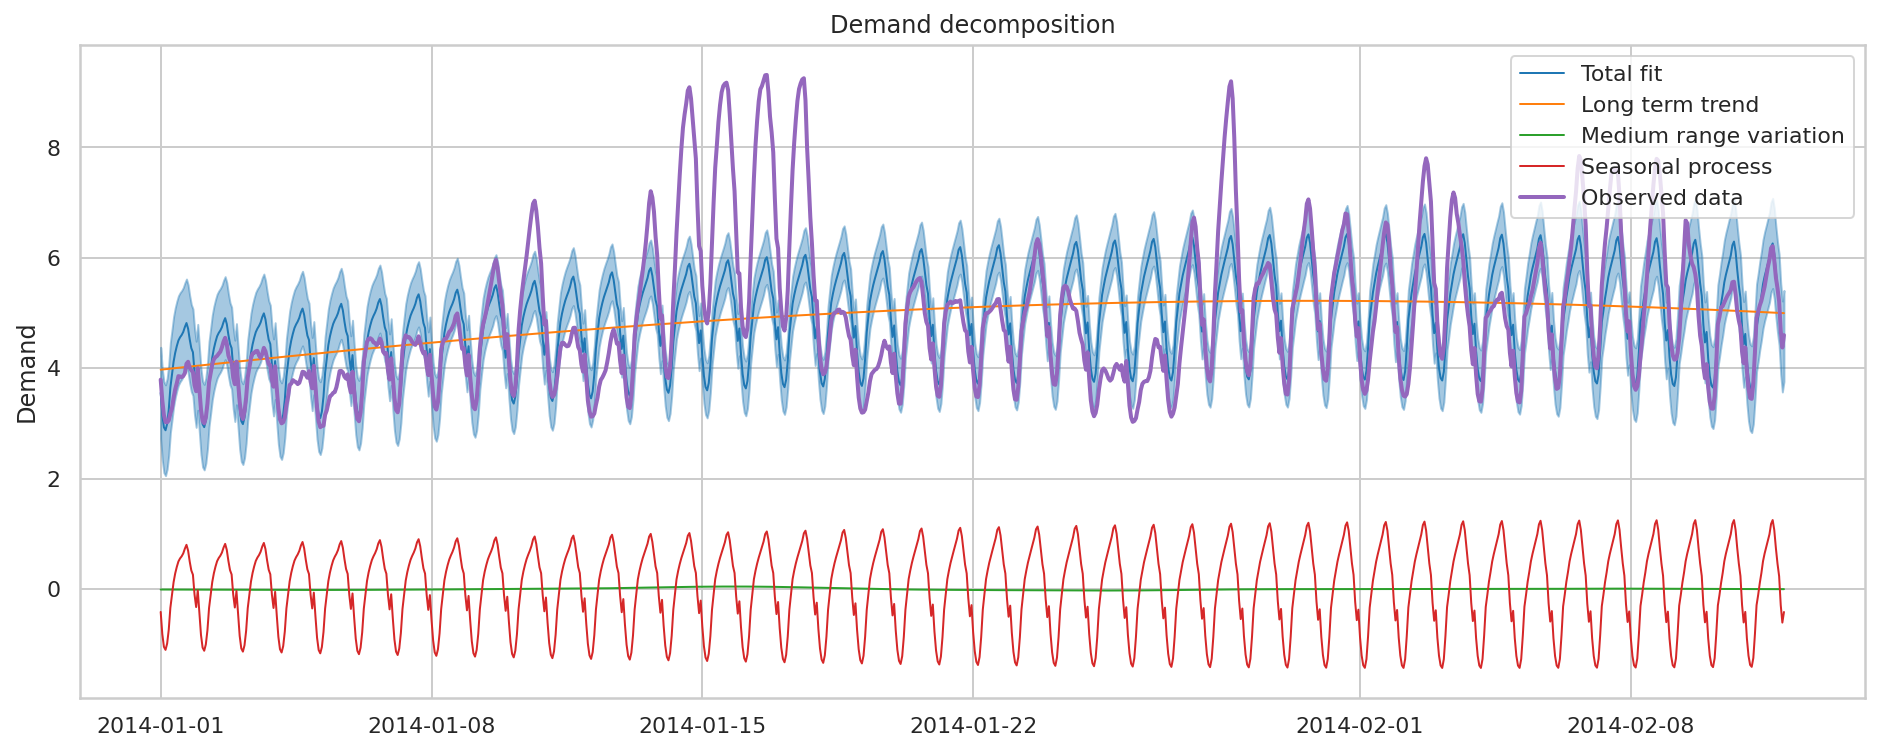

In [13]:
## plot the decompostion
fig = plt.figure(figsize=(16, 6))

# plot mean and 2σ region of total prediction
upper = fit.mu_total + 2*fit.sd_total
lower = fit.mu_total - 2*fit.sd_total
band_x = np.append(fit.index.values, fit.index.values[::-1])
band_y = np.append(lower, upper[::-1])

c = sns.color_palette()

# total fit
plt.plot(fit.index, fit.mu_total, linewidth=1, color=c[0], label="Total fit")
plt.fill_between(fit.index, lower, upper, color=c[0], alpha=0.4)

# trend
plt.plot(fit.index, fit.mu_trend, linewidth=1, color=c[1], label="Long term trend")

# medium
plt.plot(fit.index, fit.mu_medium, linewidth=1, color=c[2], label="Medium range variation")

# seasonal
plt.plot(fit.index, fit.mu_seasonal, linewidth=1, color=c[3], label="Seasonal process")

# true value
plt.plot(data_training.date, data_training.demand, linewidth=2, color=c[4], label="Observed data")

plt.ylabel("Demand")
plt.title("Demand decomposition")
plt.legend(loc="upper right")
plt.show();

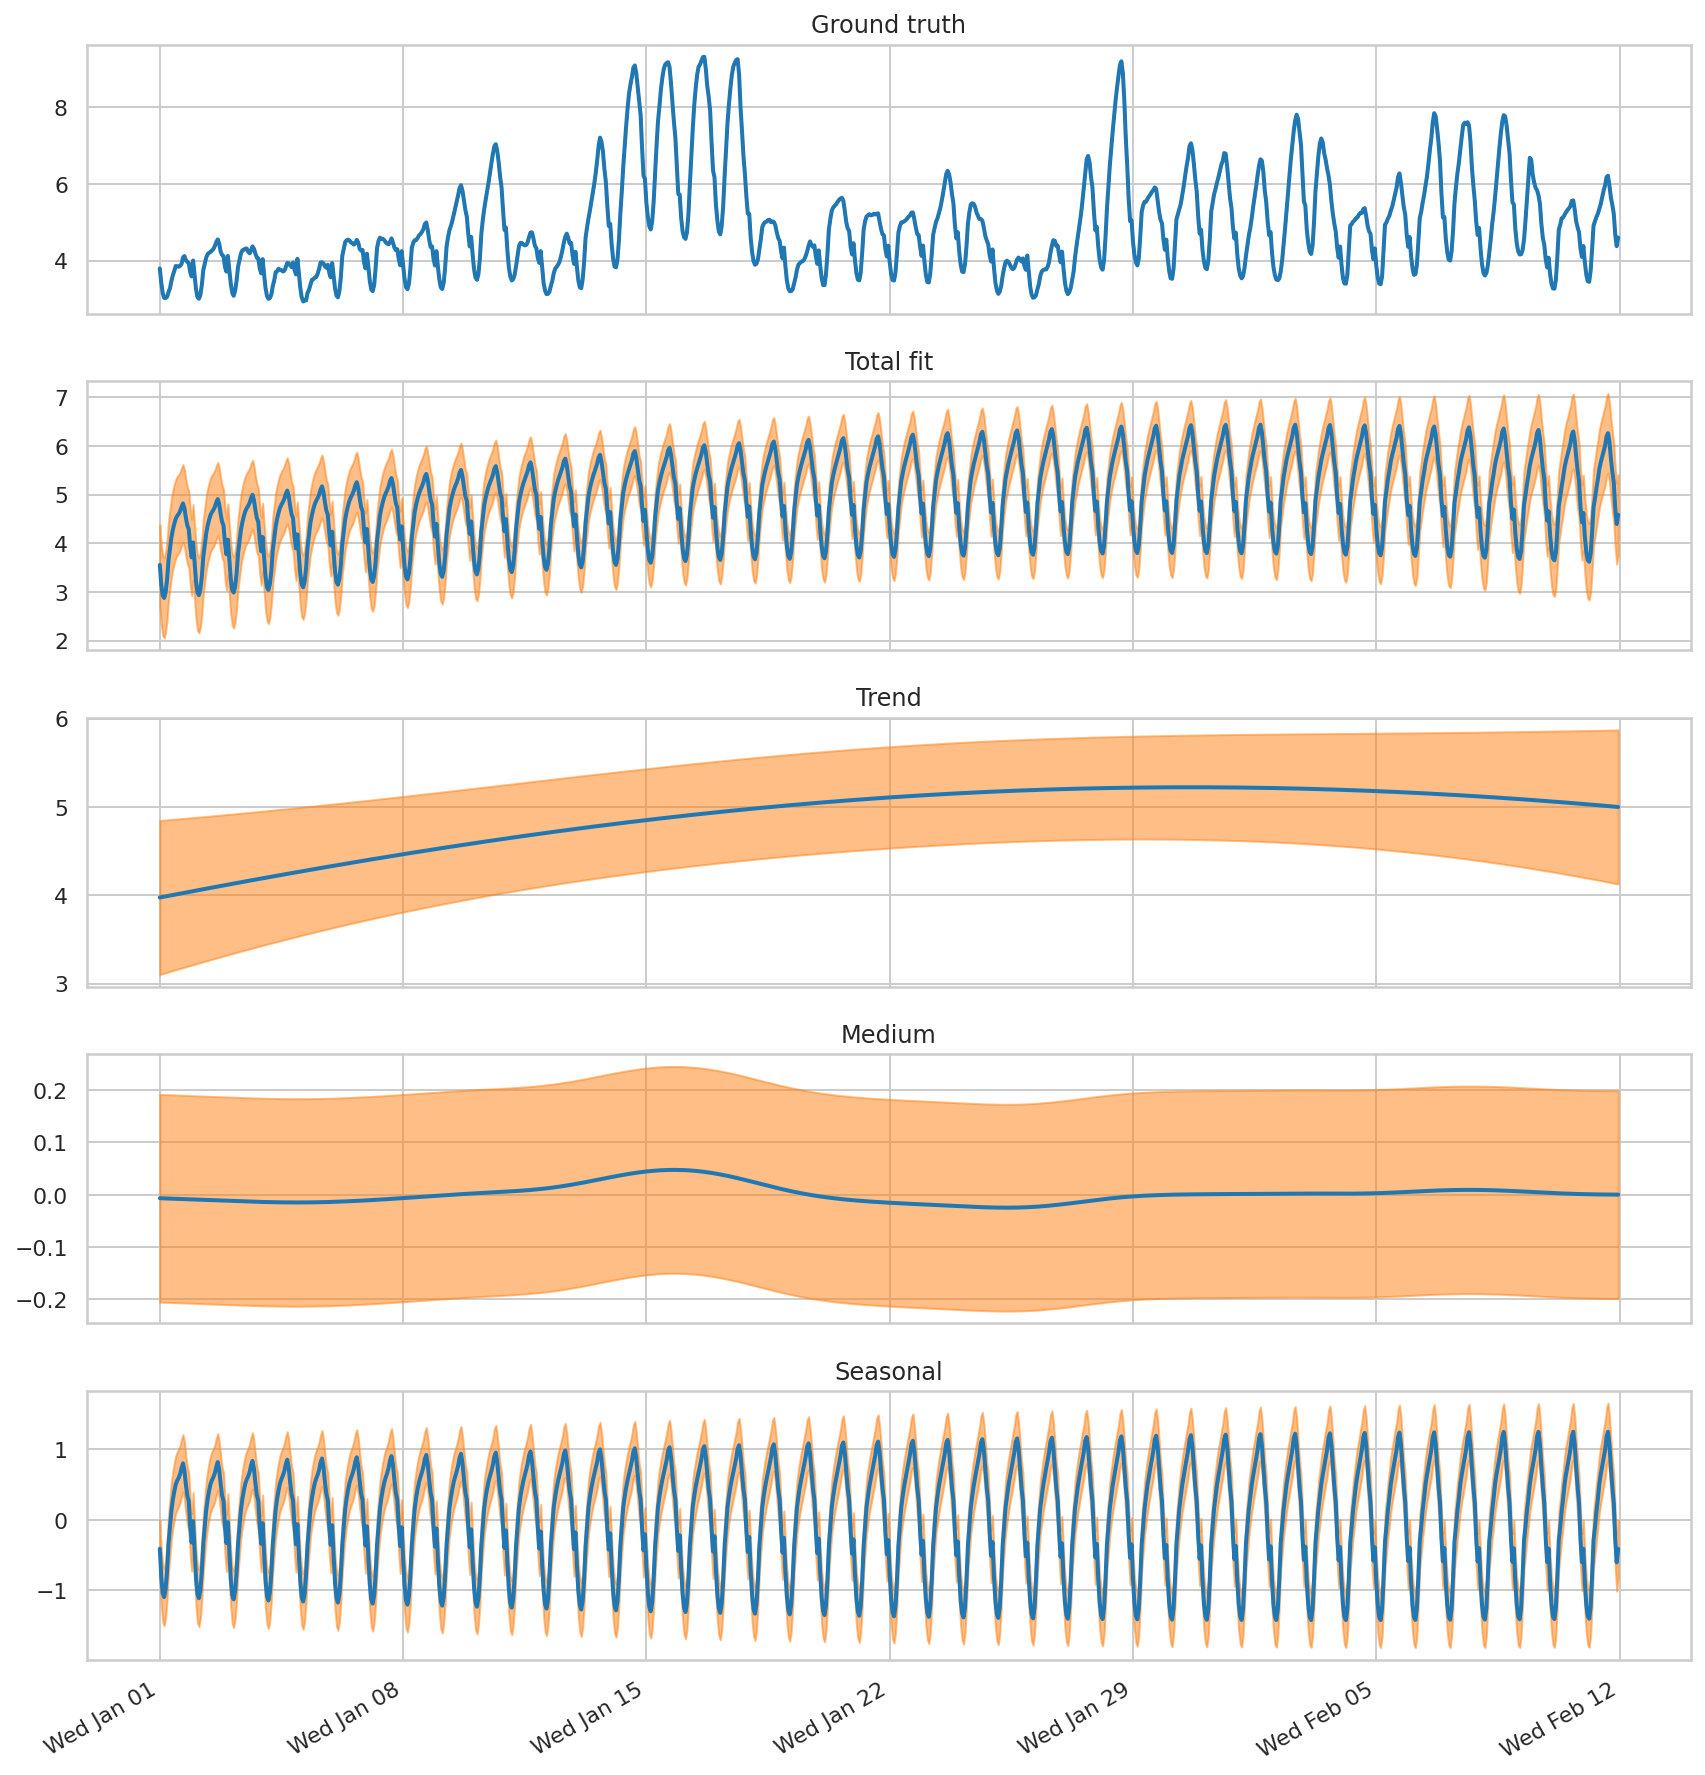

In [14]:
# plot separate components of the decomposition 
demand_component_means = {
    'Ground truth': data_training.demand,
    'Total fit': fit.mu_total,
    'Trend': fit.mu_trend,
    'Medium': fit.mu_medium,
    'Seasonal': fit.mu_seasonal,
}
demand_component_stddevs = {
    'Ground truth': np.zeros(len(data_training.demand)),
    'Total fit': fit.sd_total,
    'Trend': fit.sd_trend,
    'Medium': fit.sd_medium,
    'Seasonal': fit.sd_seasonal,
}

fig, axes = plot_components(
  data_training.date,
  demand_component_means,
  demand_component_stddevs,
  x_locator=demand_loc, x_formatter=demand_fmt)

## Demand Series Prediction

In [ ]:
dates = pd.date_range(start='2014-02-12', end="2014-02-26", freq="1H")[:-1]
tnew = dates_to_idx(dates)[:,None]

print("Sampling gp predictions...")
mu_pred, cov_pred = gp.predict(tnew, point=mp)

# draw samples, and rescale
n_samples = 2000
samples = pm.MvNormal.dist(mu=mu_pred, cov=cov_pred).random(size=n_samples)
samples = samples * std_y + first_y

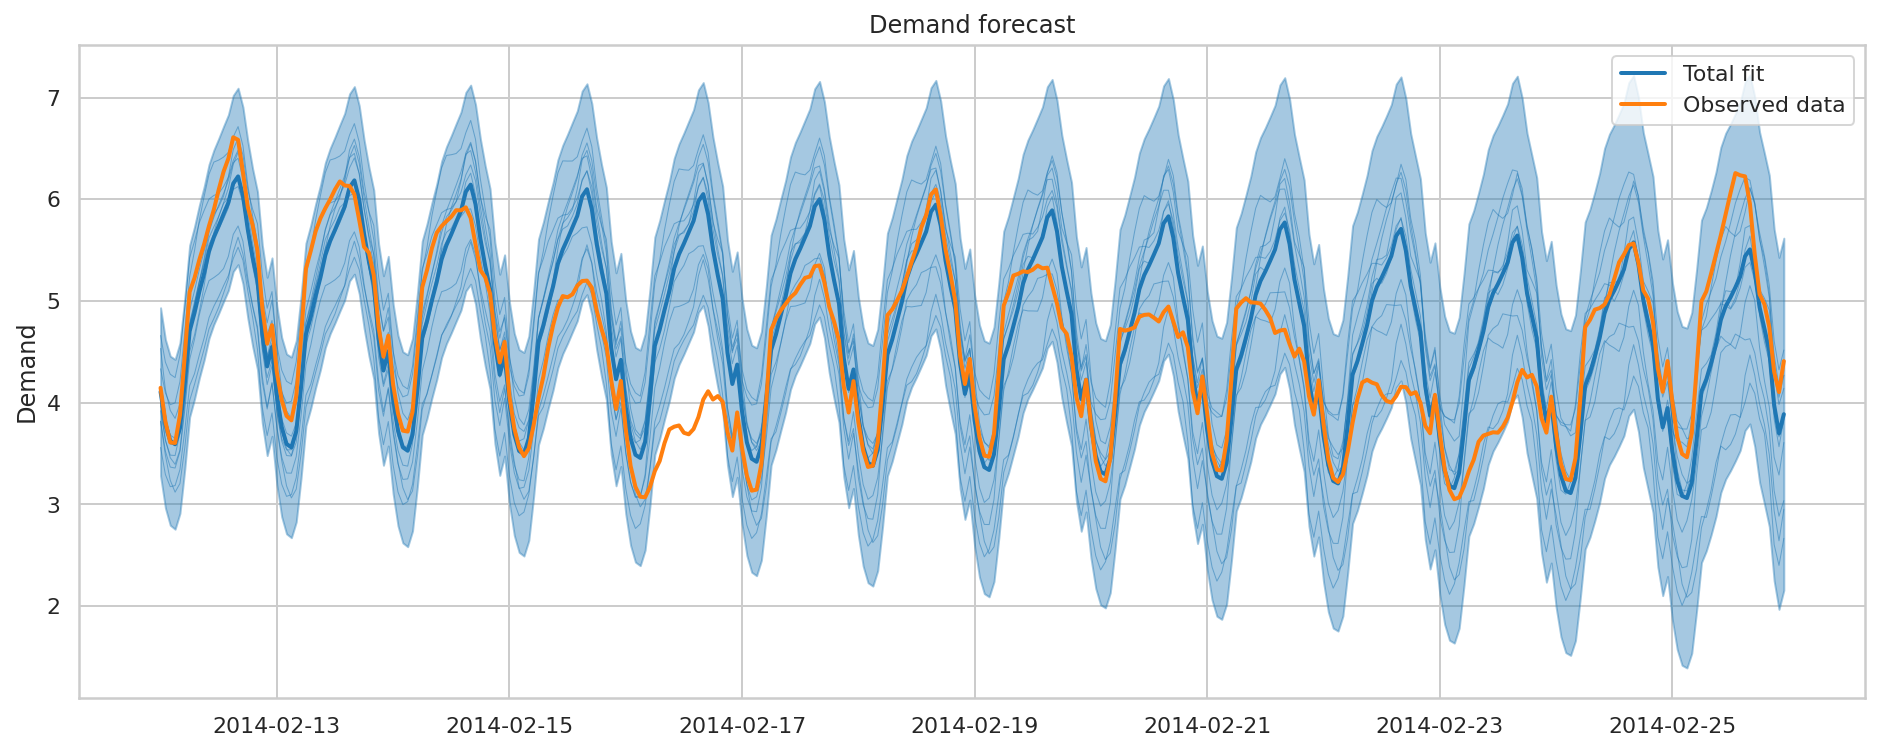

In [19]:
### plot mean and 2σ region of total prediction
fig = plt.figure(figsize=(16, 6))

# scale mean and var
mu_pred_sc = mu_pred * std_y + first_y
sd_pred_sc = np.sqrt(np.diag(cov_pred) * std_y**2 )
upper = mu_pred_sc + 2*sd_pred_sc
lower = mu_pred_sc - 2*sd_pred_sc

c = sns.color_palette()
plt.plot(data_test.date, mu_pred_sc, linewidth=2, color=c[0], label="Total fit")
plt.fill_between(data_test.date, lower, upper, color=c[0], alpha=0.4)

# some predictions
idx = np.random.randint(0, samples.shape[0], 10)
for i in idx:
    plt.plot(data_test.date, samples[i,:], color=c[0], alpha=0.5, linewidth=0.5)

# true value
plt.plot(data_test.date, data_test.demand, linewidth=2, color=c[1], label="Observed data")

plt.ylabel("Demand")
plt.title("Demand forecast")
plt.legend(loc="upper right")
plt.show();

# Part 2. Decomposition and Forecasting Using TensorFlow Probability

In [44]:
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

tf.enable_v2_behavior()

## Model Specification and Fitting

In [46]:
def build_model(observed_time_series, temperature):
    
  hour_of_day_effect = sts.Seasonal(
      num_seasons=24,
      observed_time_series=observed_time_series,
      name='hour_of_day_effect')

  day_of_week_effect = sts.Seasonal(
      num_seasons=7, num_steps_per_season=24,
      observed_time_series=observed_time_series,
      name='day_of_week_effect')
    
  temperature_effect = sts.LinearRegression(
      design_matrix=tf.reshape(temperature - np.mean(temperature), (-1, 1)), 
      name='temperature_effect')

  autoregressive = sts.Autoregressive(
      order=1,
      observed_time_series=observed_time_series,
      name='autoregressive')
    
  model = sts.Sum([hour_of_day_effect,
                   day_of_week_effect,
                   temperature_effect,
                   autoregressive],
                   observed_time_series=observed_time_series)
  return model

In [47]:
demand_model = build_model(data_training.demand, data_training.temperature)
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=demand_model)

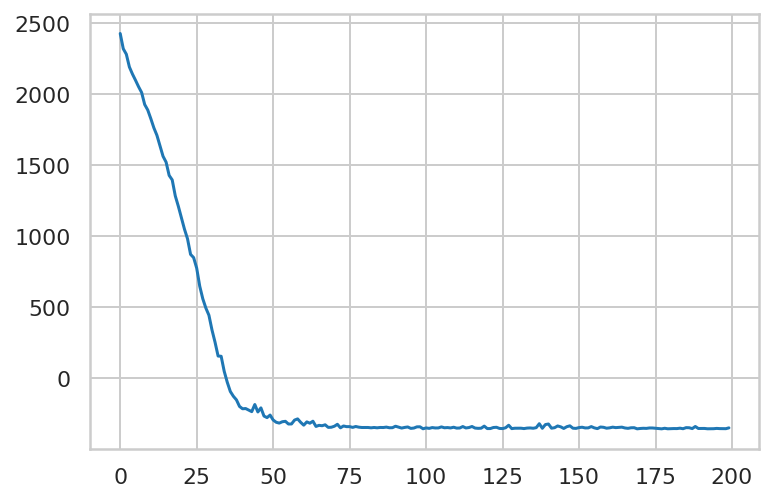

In [48]:
# Minimize the variational loss.

num_variational_steps = 200 
num_variational_steps = int(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)
# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
  elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=demand_model.joint_log_prob(observed_time_series=data_training.demand),
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_variational_steps)
  return elbo_loss_curve

elbo_loss_curve = train()

plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples_demand_ = variational_posteriors.sample(50)

In [49]:
print("Inferred parameters:")
for param in demand_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_demand_[param.name], axis=0),
                              np.std(q_samples_demand_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 0.006441253344030327 +- 0.003225005991519678
hour_of_day_effect/_drift_scale: 0.001089846902301295 +- 0.0010327067991889615
day_of_week_effect/_drift_scale: 0.0048868003768991935 +- 0.00250436773357155
temperature_effect/_weights: [0.05061767] +- [0.00352499]
autoregressive/_coefficients: [0.98365428] +- [0.00390698]
autoregressive/_level_scale: 0.14717232110050152 +- 0.0027086011076422572


## Demand Forecasting

In [50]:
demand_forecast_dist = tfp.sts.forecast(
    model=demand_model,
    observed_time_series=data_training.demand,
    parameter_samples=q_samples_demand_,
    num_steps_forecast=num_forecast_steps)

In [51]:
num_samples=10

(
    demand_forecast_mean,
    demand_forecast_scale,
    demand_forecast_samples
) = (
    demand_forecast_dist.mean().numpy()[..., 0],
    demand_forecast_dist.stddev().numpy()[..., 0],
    demand_forecast_dist.sample(num_samples).numpy()[..., 0]
)

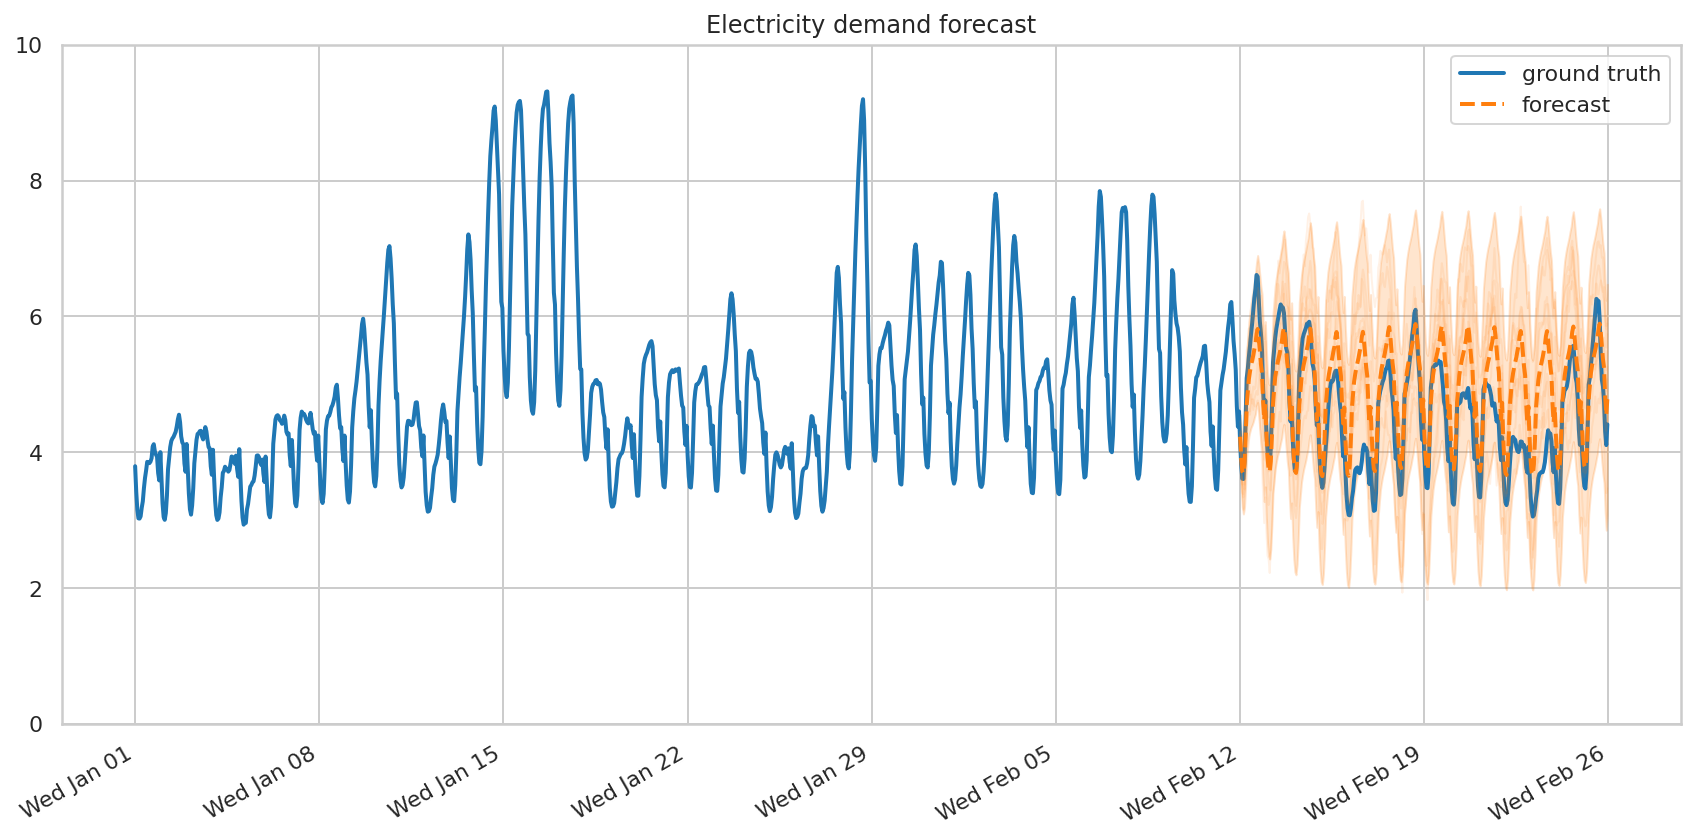

In [52]:
fig, ax = plot_forecast(demand_dates, data.demand,
                        demand_forecast_mean,
                        demand_forecast_scale,
                        demand_forecast_samples,
                        title="Electricity demand forecast",
                        x_locator=demand_loc, x_formatter=demand_fmt)
ax.set_ylim([0, 10])
fig.tight_layout()

## Demand Decomposition and Forecast Decomposition

In [53]:
# Get the distributions over component outputs from the posterior marginals on
# training data, and from the forecast model.
component_dists = sts.decompose_by_component(
    demand_model,
    observed_time_series=data_training.demand,
    parameter_samples=q_samples_demand_)

forecast_component_dists = sts.decompose_forecast_by_component(
    demand_model,
    forecast_dist=demand_forecast_dist,
    parameter_samples=q_samples_demand_)

In [54]:
demand_component_means_, demand_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()}
)

demand_forecast_component_means_, demand_forecast_component_stddevs_ = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
)

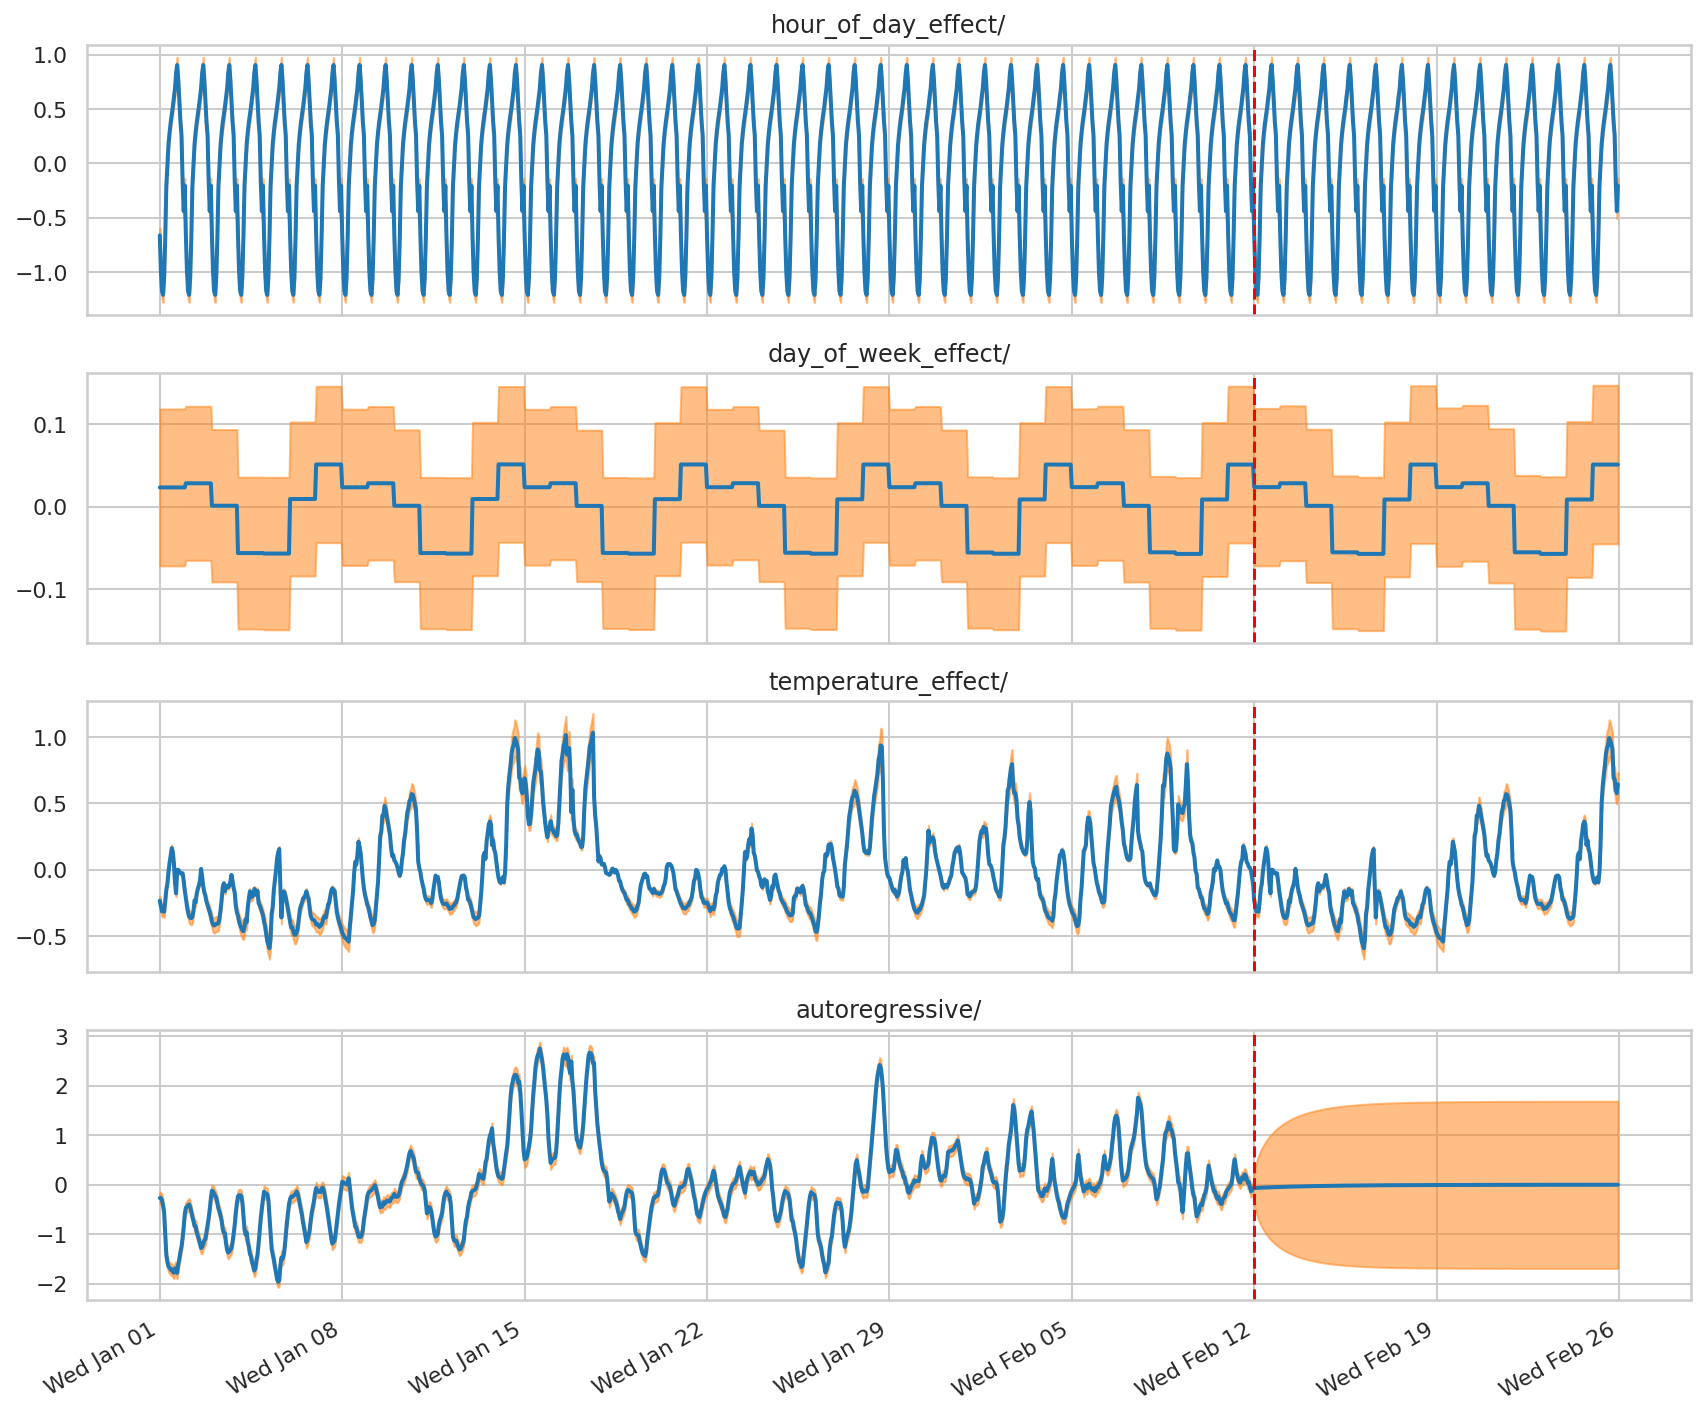

In [55]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
for k in demand_component_means_.keys():
  component_with_forecast_means_[k] = np.concatenate([
      demand_component_means_[k],
      demand_forecast_component_means_[k]], axis=-1)
  component_with_forecast_stddevs_[k] = np.concatenate([
      demand_component_stddevs_[k],
      demand_forecast_component_stddevs_[k]], axis=-1)

fig, axes = plot_components(
  demand_dates,
  component_with_forecast_means_,
  component_with_forecast_stddevs_,
  x_locator=demand_loc, x_formatter=demand_fmt)
for ax in axes.values():
  ax.axvline(demand_dates[-num_forecast_steps], linestyle="--", color='red')

# Part 3. Decomposition and Forecasting Using Facebook's Prophet

In [56]:
from fbprophet import Prophet

In [ ]:
df = data_training.rename(columns={'date':'ds', 'demand':'y'})

m = Prophet()
m.fit(df)

In [58]:
future = m.make_future_dataframe(periods=num_forecast_steps, freq='H')
future.tail()

,ds
1339,2014-02-25 19:00:00
1340,2014-02-25 20:00:00
1341,2014-02-25 21:00:00
1342,2014-02-25 22:00:00
1343,2014-02-25 23:00:00


In [59]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1339,2014-02-25 19:00:00,5.918347,3.974057,7.968740
1340,2014-02-25 20:00:00,5.580534,3.589594,7.657144
1341,2014-02-25 21:00:00,5.318659,3.381313,7.424889
1342,2014-02-25 22:00:00,5.133701,3.246054,7.139835
1343,2014-02-25 23:00:00,4.949919,2.916834,7.097435


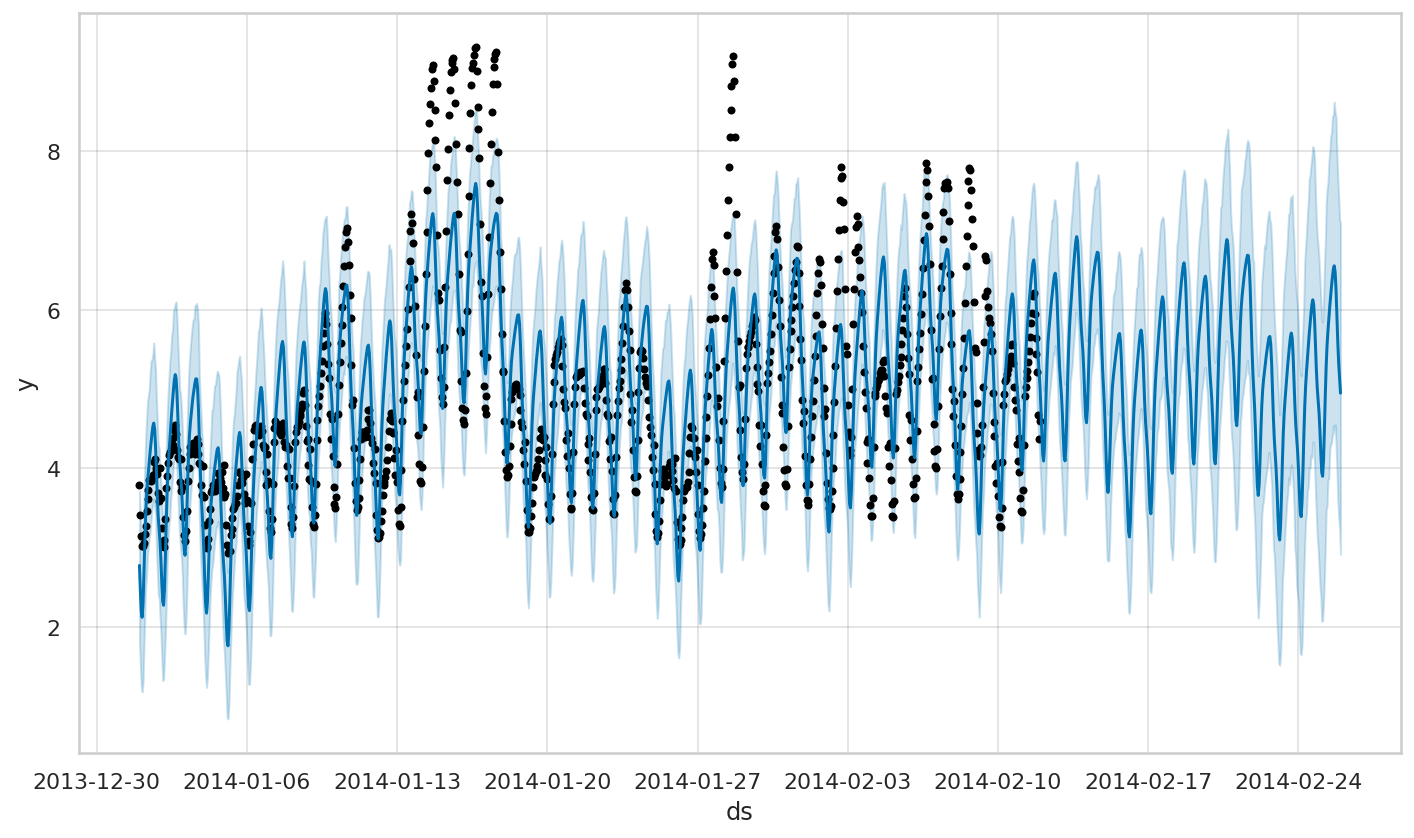

In [60]:
fig1 = m.plot(forecast)

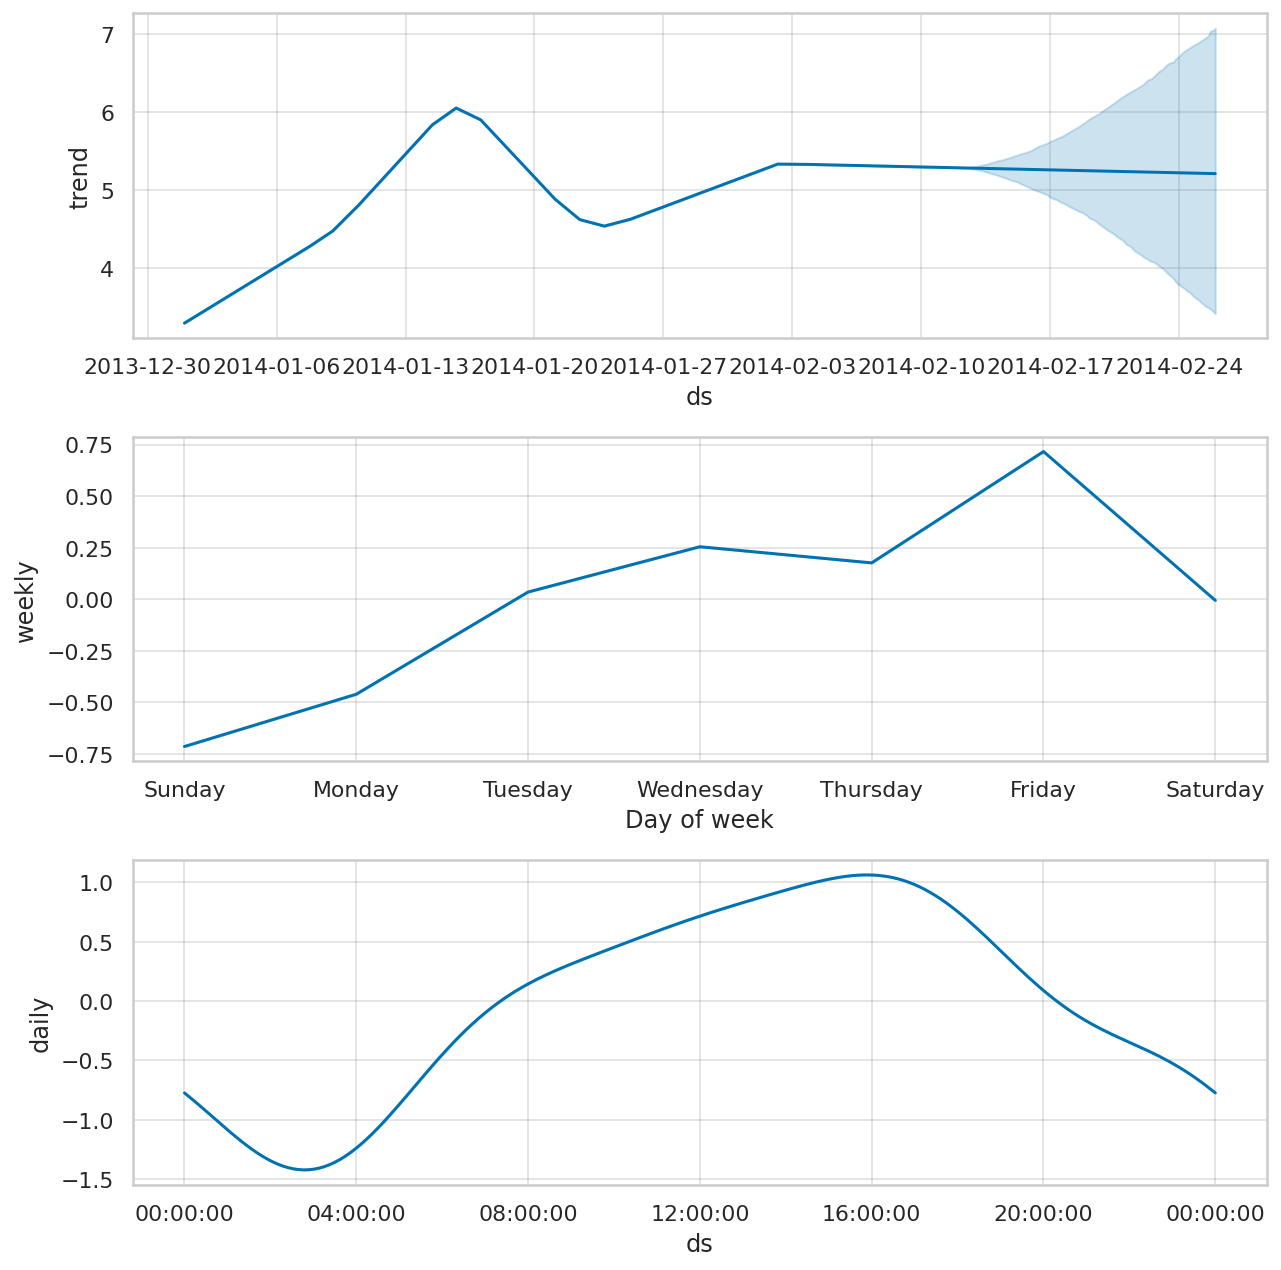

In [61]:
fig2 = m.plot_components(forecast)